# Notebook 2 - Community/Module detection within features of metabolomic dataset. 

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland. Here, the goal is to generate a correlation matrix from a metabolomic dataset and detect communities/modules of highly connected features.

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import community  # python-louvain package

## Define functions:

In [2]:
def find_common_keys(my_dict,dict_value):

    # Using a loop
    keys_with_searched_value = []
    for key, value in my_dict.items():
        if value == dict_value:
            keys_with_searched_value.append(key)

    # Or using a dictionary comprehension
    keys_with_searched_value = [key for key, value in my_dict.items() if value == dict_value]
    return keys_with_searched_value

## Load normalised metabolomics data, and calculate the correlation matrix of the features:

In [5]:
expression_data = pd.read_csv('All_data_normalised_21DEC2023.csv',index_col=0).reset_index(drop = True).T
correlation_matrix = np.corrcoef(expression_data)

## Create a *networkx* graph object from the correlation matrix:

In [6]:
adj_mat = np.array(np.abs(correlation_matrix))
G = nx.Graph()

# Add nodes
num_nodes = len(adj_mat)
G.add_nodes_from(range(1, num_nodes + 1))

# Add weighted edges
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_mat[i, j]
        G.add_edge(i + 1, j + 1, weight=weight)

## Define communities of features using the Louvain method:

In [7]:
communities = nx.algorithms.community.louvain_communities(G,resolution = 2, weight='weight',seed=142)
sorted_communities = sorted(communities)

## Get the average weight of each node in each community (will help with identifying the most connected node in each community)

In [8]:
dict_communities_degree = []
for sub in range(0,len(sorted_communities)):
    subgraph_nodes = sorted_communities[sub]
    subgraph = G.subgraph(subgraph_nodes)
    node_degrees = dict(subgraph.degree())
    node_weights = dict(subgraph.degree(weight='weight'))
    node_ave_weight = {key: node_weights[key] / (node_degrees[key]+0.0001) for key in node_weights}
    dict_communities_degree.append(dict(sorted(node_ave_weight.items())))
    
degree_dict = {e: list(dictt.values())[idxx] for i, dictt in enumerate(dict_communities_degree) for idxx, e in enumerate(list(dictt.keys()))}
sorted_degree_dict = {node: degree_dict[node+1] for node in range(len(G.nodes))}

community_dict = {node: i for i, nodes in enumerate(sorted_communities) for node in nodes}
# Create a dictionary where keys are node indices and values are their community memberships
sorted_community_dict = {node: community_dict[node+1] for node in range(len(G.nodes))}

## Make a *pandas* DataFrame to keep the information about the community membership and average community-localised weight of each node: 

In [9]:
df_modules = pd.DataFrame([expression_data.T.columns.tolist(),list(sorted_community_dict.values()),list(sorted_degree_dict.values())]).T
df_modules.columns = ['Feature','Module','Weighted.degree']

# Count the number of individuals in each group
group_counts = df_modules['Module'].value_counts()

# Identify groups with fewer than 2 individuals
small_groups = group_counts[group_counts < 2].index

# Replace group numbers for small groups with a new group number (e.g., 0)
df_modules['Module'] = df_modules['Module'].apply(lambda x: 1000 if x in small_groups else x)


## To facilitate the correlation analysis of each community with clinical variables, decompose them into eigenvectors and eigenvalues:

In [10]:
eigenvectors_df = []

for k in df_modules['Module'].unique():
    print(k)
    features = df_modules[df_modules['Module'] == k]['Feature'].tolist()
    ids = np.where(np.array(df_modules['Module'])==k)
    subset = expression_data.T.iloc[:,ids[0]]
    subset_array = subset.to_numpy()

    # Perform eigendecomposition on the subset array
    U, S, Vt = np.linalg.svd(subset_array.T, full_matrices=False)
    
    # Print how much of the variation the first PC explains:
    explained_variance = (S ** 2) / np.sum(S ** 2)
    print(round(explained_variance[0]*100,2),'%')

    # Extract the principal components (eigenvectors) from Vt
    eigenvectors = Vt[0]

    # Store eigenvectors in the result list
    eigenvectors_df.append(eigenvectors)
    
eigendf = pd.DataFrame(eigenvectors_df).T
eigendf.columns = df_modules['Module'].unique()

27
50.5 %
5
36.92 %
8
39.72 %
15
41.3 %
0
46.63 %
23
57.21 %
11
48.08 %
10
47.46 %
20
54.17 %
9
37.0 %
40
54.77 %
63
37.29 %
6
68.45 %
7
40.7 %
68
47.65 %
13
62.29 %
14
46.3 %
17
49.31 %
72
48.73 %
4
45.13 %
75
39.42 %
49
48.46 %
19
42.47 %
83
42.93 %
26
55.4 %
1
55.99 %
82
39.19 %
22
48.77 %
39
40.01 %
79
54.05 %
65
42.18 %
89
62.77 %
2
45.16 %
24
47.32 %
34
41.94 %
36
34.9 %
44
53.48 %
48
46.2 %
60
45.06 %
29
48.73 %
84
57.86 %
41
48.66 %
47
47.12 %
18
62.21 %
37
44.99 %
30
45.0 %
3
40.13 %
81
40.98 %
12
50.01 %
61
35.52 %
25
56.23 %
80
41.31 %
21
54.72 %
66
47.05 %
73
51.98 %
53
42.46 %
67
39.8 %
85
60.08 %
90
44.14 %
16
46.61 %
70
54.95 %
42
38.39 %
28
49.09 %
38
35.28 %
50
39.3 %
52
41.74 %
43
31.16 %
45
39.35 %
69
39.59 %
32
53.95 %
46
39.91 %
35
52.11 %
58
59.7 %
74
76.69 %
57
52.57 %
77
56.32 %
31
71.18 %
71
46.69 %
33
67.94 %
87
47.3 %
54
50.71 %
55
46.4 %
76
44.57 %
51
70.27 %
88
53.41 %
62
54.81 %
56
61.79 %
64
34.72 %
86
36.53 %
78
54.5 %
59
54.7 %


## Read in clinical data and correlate with the feature communities:

<Figure size 2500x600 with 0 Axes>

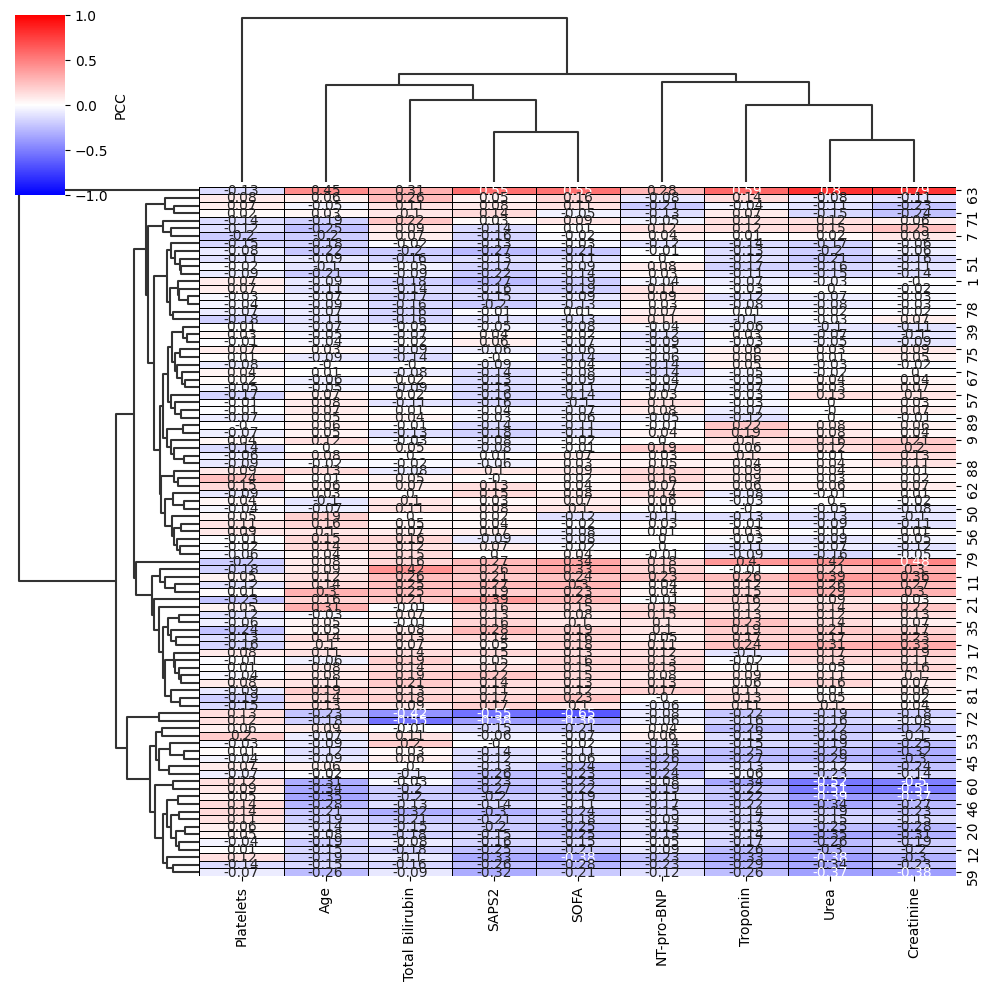

In [11]:
clin_orig = pd.read_csv('Clinical_data_covid_study_2023.csv')
new_df = pd.concat([eigendf, clin_orig], axis=1).corr(method = 'pearson').filter(clin_orig.columns).filter(eigendf.columns, axis=0)
new_df = new_df[['Age','SAPS2','SOFA','NT-pro-BNP','Urea','Creatinine','Troponin','Platelets','Total_bilirubin']]
new_df = new_df.rename(columns = {'Total_bilirubin':'Total Bilirubin'})


import seaborn as sns
new_annots = round(new_df,2)
plt.figure(figsize = (25,6))
figg = sns.clustermap(new_df, 
        xticklabels=new_df.columns,
           cmap = 'bwr', cbar_kws={'label': 'PCC'}, 
               annot = new_annots,
              linewidths = 0.5, linecolor = 'black',
              vmin=-1, vmax=1)
for a in figg.ax_row_dendrogram.collections:
    a.set_linewidth(1.5)

for a in figg.ax_col_dendrogram.collections:
    a.set_linewidth(1.5)
#plt.savefig("clustermap_JAN2024.svg")
plt.show()

## Make a correlation dataframe (will help with annotation procedure):

In [12]:
correlation_df = pd.DataFrame(index=eigendf.columns, columns=expression_data.index)

# Iterate over columns of eigendf and calculate the correlation with expression_data
for eigencol in eigendf.columns:
    correlations = expression_data.apply(lambda row: row.corr(eigendf[eigencol],method = 'pearson'), axis=1)
    correlation_df.loc[eigencol] = correlations

correlation_df = correlation_df.T

## Save relevant data:

In [15]:
correlation_df.to_csv('correlation_df_JAN2024.csv')
eigendf.to_csv('eigendf_JAN2024.csv')
df_modules.to_csv('df_modules_JAN2024.csv')